In [1]:
import json
import boto3
import botocore
import PIL
import io
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from io import BytesIO

In [116]:
# aws_region = "us-west-2"

font = ImageFont.truetype("C:\Windows\Fonts\calibrib.ttf", 70)
font

In [202]:
s3 = boto3.client("s3")
bucket = "mgt-hnjng"
object_key = "mzc_project/test-image/20200715_131414.jpg"
save_path = "mzc_project/save-image"
save_name = "bbox_test2"

source_img = s3.get_object(Bucket=bucket, Key=object_key)["Body"].read()

In [203]:
runtime = boto3.Session().client("sagemaker-runtime")
endpoint = "ObjectDetection-2020-10-26"

In [204]:

# inference_image = Image.open(io.BytesIO(source_img))

response = runtime.invoke_endpoint(
    EndpointName=endpoint, 
    ContentType="application/x-image",
    Body=source_img
)
result = json.loads(response["Body"].read().decode())
print(result)  # Label 번호, 신뢰도, 좌표

{'prediction': [[1.0, 0.9392359256744385, 0.47723376750946045, 0.31113487482070923, 0.6052666902542114, 0.5349977016448975], [0.0, 0.5453110337257385, 0.2958245277404785, 0.3287852704524994, 0.46411406993865967, 0.6073092222213745], [2.0, 0.2749600112438202, 0.618650496006012, 0.3478635549545288, 0.6755312085151672, 0.5197361707687378], [0.0, 0.03424099087715149, 0.3458176255226135, 0.339533269405365, 0.533976674079895, 0.5795513391494751]]}


In [205]:
source_img = Image.open(io.BytesIO(source_img))
print(source_img)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x1908 at 0x276AC969608>


In [206]:
target_object = {0.0: "KEEPER ASSY (162100422)",
                 1.0: "SWITCH ASSY (162100400)",
                 2.0: "CONTACT ASSY (162100403)",
                 3.0: "KEEPER (13100322)",
                 4.0: "GATE SWITCH (13100393)",
                 5.0: "Locking Device Clutch (131103802)",
                 6.0: "Guide Shoes (126100141, 126100142)",
                 7.0: "Fan (321103905)",
                 8.0: "Limit SW (2411T0002)"}

In [207]:
# 이미지 Boxing
for labels in result["prediction"]:
    if labels[1] >= 0.50:
        draw = ImageDraw.Draw(source_img)

        x_min = int(labels[2] * source_img.size[0])
        y_min = int(labels[3] * source_img.size[1])
        x_max = int(labels[4] * source_img.size[0])
        y_max = int(labels[5] * source_img.size[1])
 
        draw.rectangle(((x_min, y_min), (x_max, y_max)), outline="red", width=15)
    
        # Text위치 변수설정
        x, y =(x_min, y_min-130)
        text =str(target_object.get((labels[0])))
        acc= str(int(100*round(labels[1], 2)))+' %'
        print(acc)

        w, h = font.getsize(text)
        
        
        draw.rectangle((x, y ,x+w, y+2*h), fill='red')
        draw.text((x, y), text+"\n"+acc, font=font)
    
in_mem_file = io.BytesIO()
source_img.save(in_mem_file, format=source_img.format)
in_mem_file.seek(0)

94 %
55 %


0

In [208]:
w, h = font.getsize(text)
print(w,h)
w, h = w+10, h+10
print(w,h)

751 65
761 75


In [209]:
source_img.save(os.path.join(os.getcwd(), save_name+".jpg"),"JPEG")

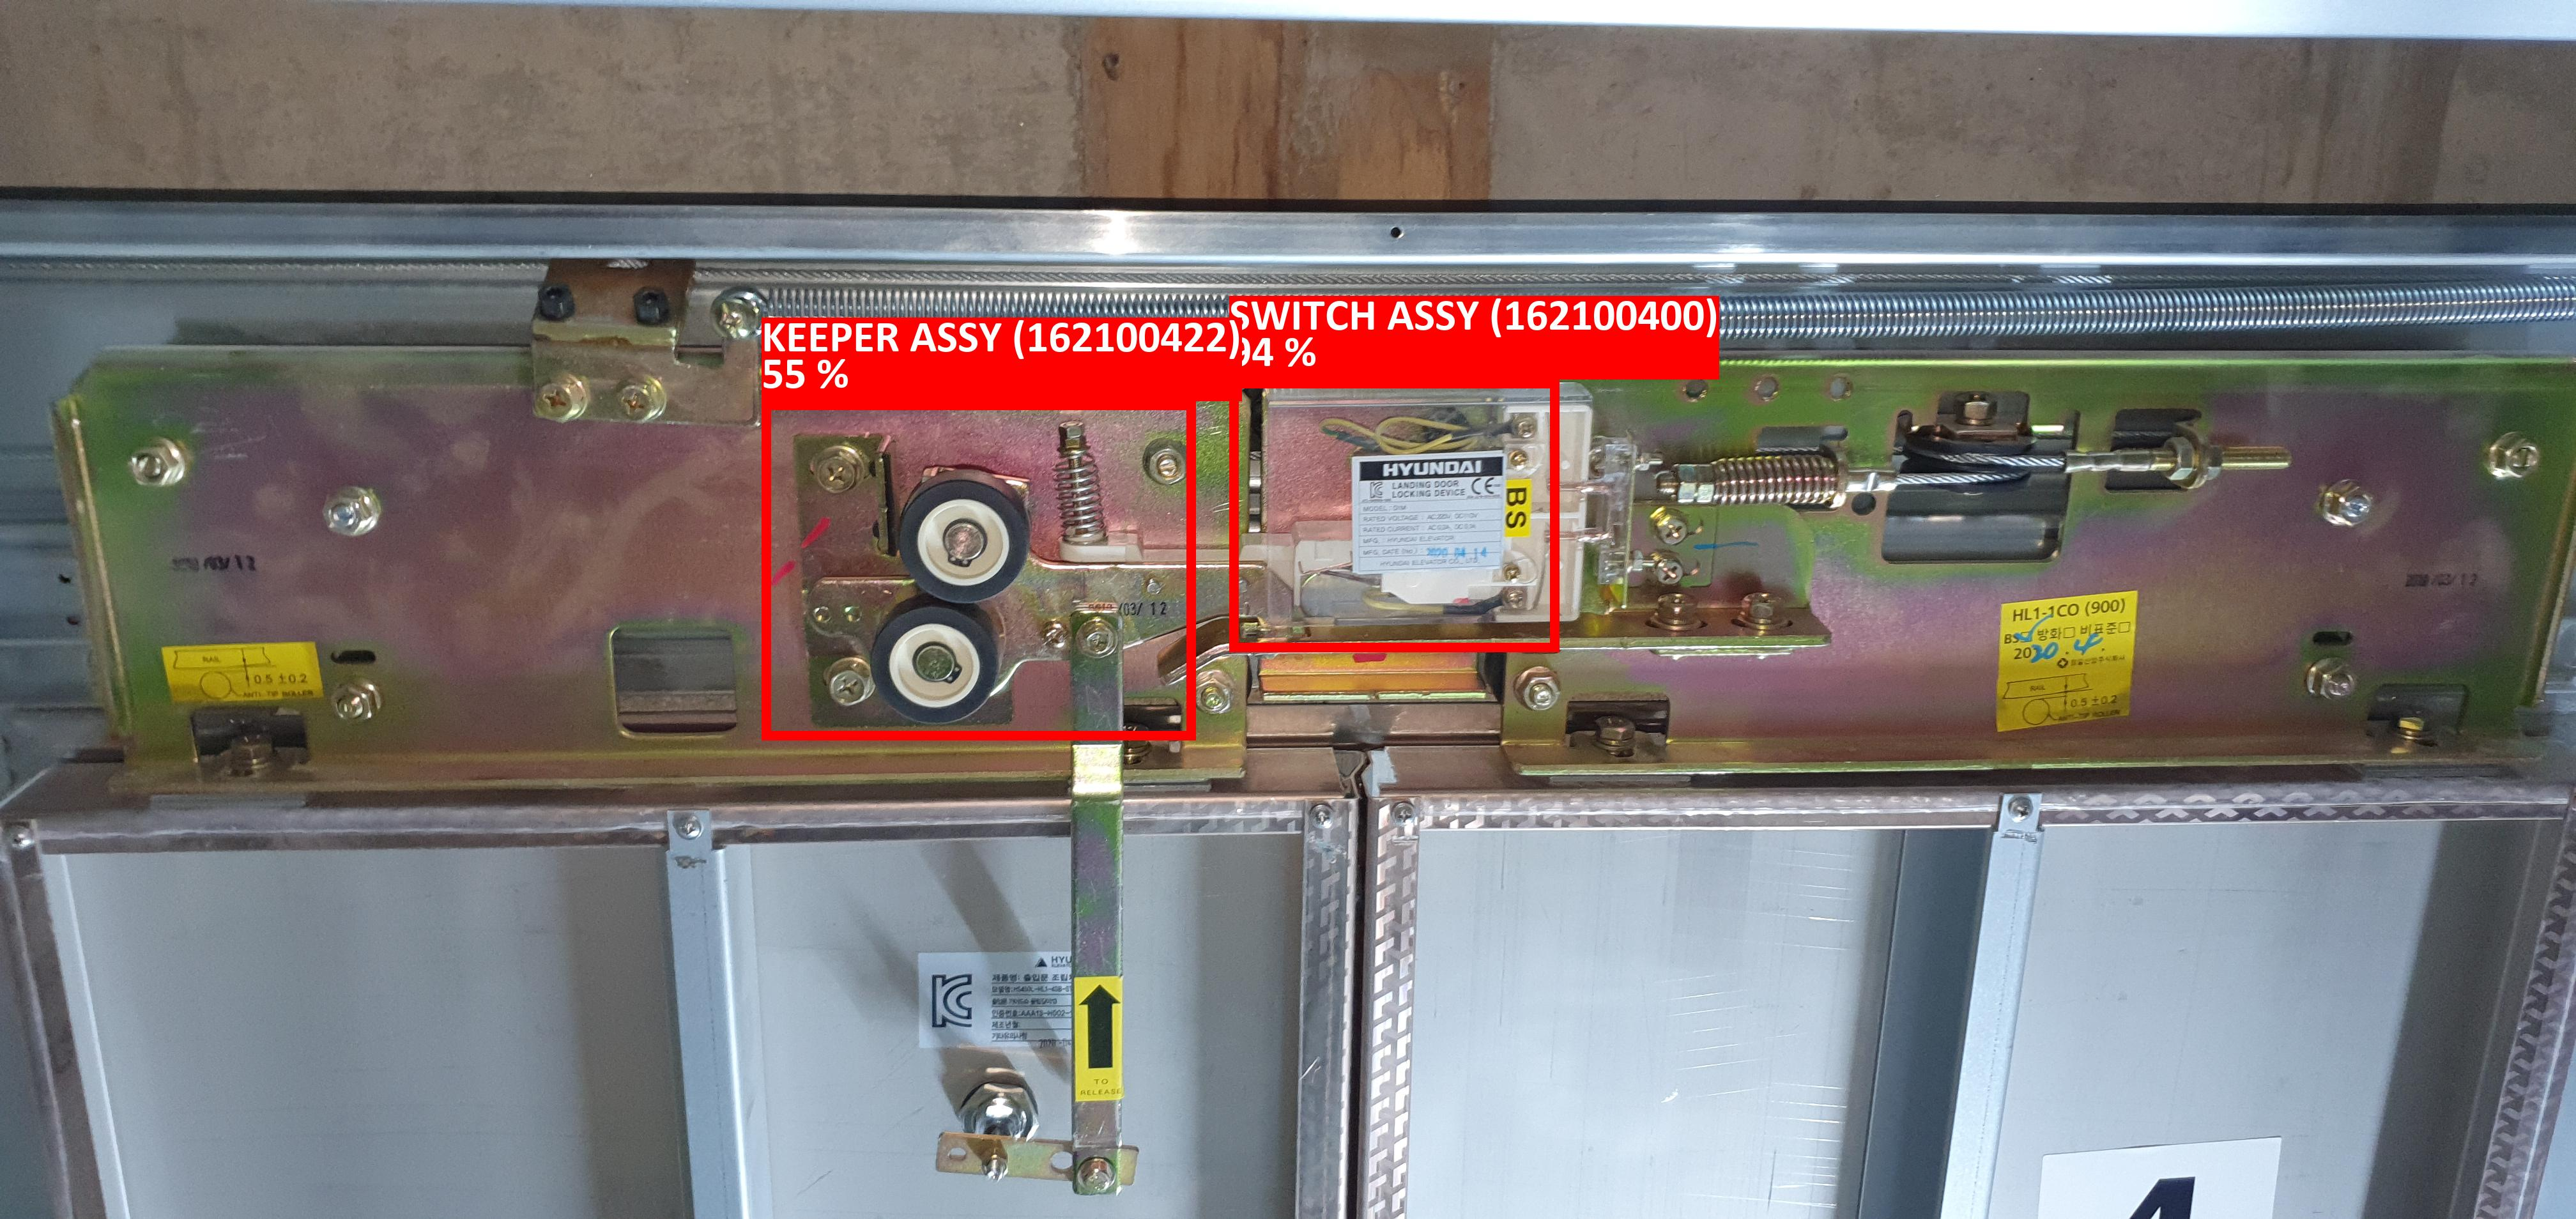

In [210]:
output_img = Image.open(os.getcwd()+'\\'+save_name+'.jpg')
output_img

In [211]:
# s3.put_object(Body=in_mem_file, Bucket=bucket, Key=save_path)